# Deeptime Notebook

A combination of the PyEMMA and Deeptime tutorials.

Last updated: Feb 24, 2023


By Jeremy Leung

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import deeptime

from tqdm.auto import tqdm

# Require deeptime, ipywidgets, tqdm. numpy and matplotlib

In [2]:
# Common variables across all checkpoints
lagtimes = [1,2,5,10,20,25]
n_clusters = [5, 10, 20, 50, 100, 200]

In [9]:
# Load in your data. Example here are 10 .npy arrays of shape (n_frames, 4). 
# Only loading in phi/psi (other two are the omega angles)
folders = [f'{num+1:02d}' for num in range(10)]
print(folders)
dihedral = []
for folder in tqdm(folders):
    dihedral.append(np.load(f'{folder}/dihedral.npy')[::10,:2])
#data = []
#for folder in tqdm(folders):
#    data.append(np.load(f'{folder}/coords.npy')[20000000:30000000:100000])
# Note if you have multiple independent trials, this concatenates them into one large array.
dihedral_concat = np.concatenate(dihedral)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']


  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
# Run K-means on multiple cluster numbers
clusters = []
dtrajs = []
for n in n_clusters:
    cluster = deeptime.clustering.KMeans(n_clusters=n, max_iter=500, progress=tqdm)
    dtraj = cluster.fit_transform(dihedral_concat)
    dtrajs.append(dtraj)
    clusters.append(cluster.fetch_model())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## Checkpoint 1/4

In [7]:
# Read previous data
import pickle
with open('clusters.pickle','rb') as file:
    clusters = pickle.load(file)
with open('dtrajs.pickle','rb') as file:
    dtrajs = pickle.load(file)

In [113]:
# Write previous data
import pickle
with open('clusters.pickle','wb') as file:
    pickle.dump(clusters, file)
with open('dtrajs.pickle','wb') as file:
    pickle.dump(dtrajs, file)

In [42]:
# Make the count matrix for various lagtimes.
lagtimes = [1,2,5,10,20,25]
countm = []
for dtraj in dtrajs:
    c_small = []
    for lag in lagtimes:
        estimator = deeptime.markov.TransitionCountEstimator(lag, 'sliding')
        c_small.append(estimator.fit(dtraj).fetch_model())
    countm.append(c_small)

## Checkpoint 2/4

In [6]:
# Read previous data
import pickle
with open('countm.pickle','rb') as file:
    countm = pickle.load(file)

In [114]:
# Write previous data
import pickle
with open('countm.pickle','wb') as file:
    pickle.dump(countm, file)

In [18]:
# Make MSM for each cluster/lagtime
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
msms = []
for matrix in countm:
    small = []
    for m, lag in zip(matrix, lagtimes):
        small.append(estimator.fit(m, lagtime=lag).fetch_model())
    msms.append(small)

## Checkpoint 3/4

In [4]:
# Read previous data
import pickle
with open('msms.pickle','rb') as file:
    msms = pickle.load(file)

In [19]:
# Write previous data
import pickle
with open('msms.pickle','wb') as file:
    pickle.dump(msms, file)

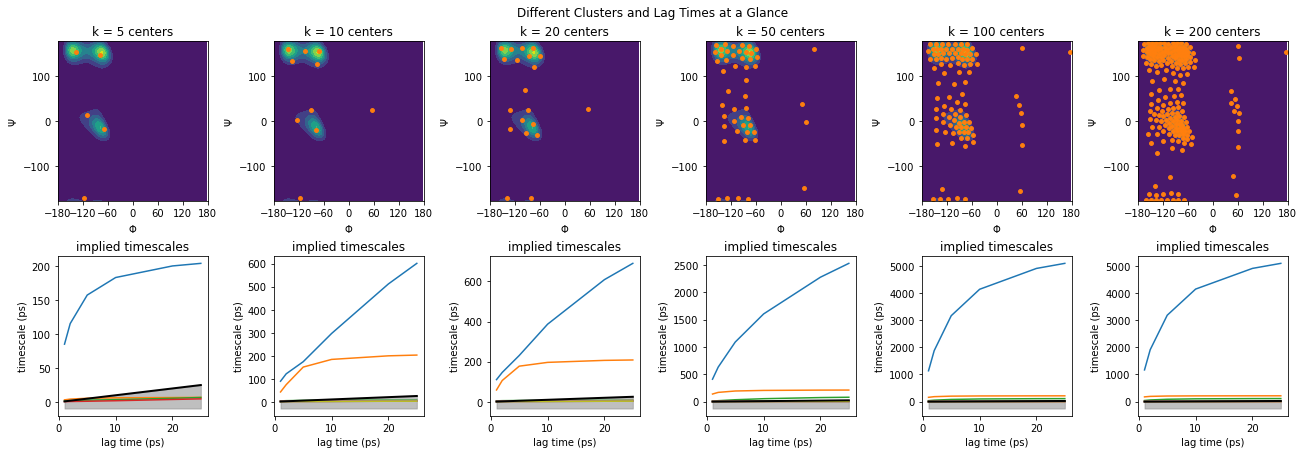

In [11]:
# Try and plot the many different cluster centers

# Setting up the figure/Axes objects...
fig = plt.figure(constrained_layout=True, figsize=(18,6.2))
gs = fig.add_gridspec(2, len(n_clusters))
axes = []
for idx in range(2):
    axes.append([])
    for jdx in range(len(n_clusters)):
        axes[idx].append(fig.add_subplot(gs[idx, jdx]))
axes = np.asarray(axes)
# This is a simplified way to setup but might create overlap
#fig, axes = plt.subplots(2, len(n_clusters), figsize=(18, 6.2))

# Plotting things...
for i, (n, cluster, dtraj, msm) in enumerate(zip(n_clusters, clusters, dtrajs, msms)):
    # Top row...
    deeptime.plots.plot_density(*dihedral_concat.T[::-1], ax=axes[0, i]) # Note .T reverses Phi/Psi
    axes[0, i].scatter(*cluster.cluster_centers.T, s=15, c='C1')
    axes[0, i].set_xlabel('$\Phi$')
    axes[0, i].set_ylabel('$\Psi$')
    axes[0, i].set_title('k = {} centers'.format(n))
    axes[0, i].set_xticks([j for j in range(-180,181,60)])
    axes[0, i].set_xticks([j for j in range(-180,181,60)])
    
    # Bottom row...
    deeptime.plots.plot_implied_timescales(
        deeptime.util.validation.implied_timescales(msm, n_its=9),
        ax=axes[1, i])
    axes[1, i].set_xlabel('lag time (ps)')
    axes[1, i].set_ylabel('timescale (ps)')
    axes[1, i].set_title('implied timescales')
    #axes[1, i].set_ylim(1, 2000)

#fig.tight_layout()
fig.suptitle('Different Clusters and Lag Times at a Glance')
fig.savefig('its.pdf', dpi=300)

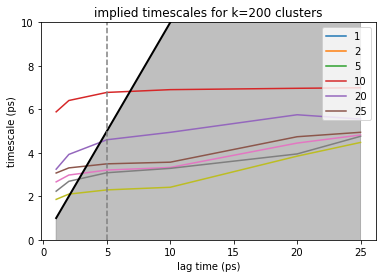

In [27]:
# Blowing one of the implied timescale plot up by replotting it.
index = -1 # Looking at the last one.
plot = deeptime.plots.plot_implied_timescales(
    deeptime.util.validation.implied_timescales(msms[index], n_its=9))
plot.set_xlabel('lag time (ps)');
plot.set_ylabel('timescale (ps)');
plot.set_title(f'implied timescales for k={n_clusters[-1]} clusters');
plot.set_ylim(0,10);
plot.axvline(5, linestyle='--', color='grey');
plot.legend(lagtimes,loc='upper right');

## Choosing 10ps * 5ps = report every 50 ps
plot.figure.savefig('final_its.pdf', dpi=300)

In [123]:
final_lag = 5
final_cluster= clusters[index]
final_dtrajs = dtrajs[index][::5]
estimator = deeptime.markov.TransitionCountEstimator(lag, 'sliding')
final_count = estimator.fit(dtraj).fetch_model()
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
final_msm = estimator.fit(final_count, lagtime=None).fetch_model()

In [124]:
final_msm.transition_matrix

array([[0.01034823, 0.00073576, 0.00031804, ..., 0.01844174, 0.00076898,
        0.00087341],
       [0.00031855, 0.01187036, 0.00507614, ..., 0.00048091, 0.01423786,
        0.01278281],
       [0.00032703, 0.01205584, 0.0052909 , ..., 0.00040024, 0.01384225,
        0.01249021],
       ...,
       [0.01028488, 0.00061947, 0.00021708, ..., 0.01847312, 0.00067506,
        0.00071477],
       [0.00028591, 0.01222685, 0.0050051 , ..., 0.00045004, 0.01429524,
        0.01237683],
       [0.00036609, 0.01237533, 0.00509139, ..., 0.0005372 , 0.01395308,
        0.01240714]])

In [14]:
# Read previous data
import pickle
with open('final.pickle','rb') as file:
    [final_cluster, final_dtrajs, final_count, final_msm] = pickle.load(file)

In [125]:
# Write previous data
import pickle
with open('final.pickle','wb') as file:
    pickle.dump([final_cluster, final_dtrajs, final_count, final_msm], file)

## Checkpoint 4

In [122]:
np.save('final_transition_matrix_200clusters.npy', final_msm.transition_matrix)

In [7]:
# Finding the index of frames closest to center
from scipy.cluster.vq import vq
cl, _ = vq(final_cluster.cluster_centers, dihedral_concat[::50])

np.save('closest_index.npy', cl)

In [ ]:
# Loading in the coordinates
folders = [f'{num+1:02d}' for num in range(10)]
data = []
for folder in tqdm(folders):
    data.append(np.load(f'{folder}/coords.npy'))[::10]
data_concat2 = np.concatenate(data)[::50]

In [ ]:
dihedral_concat2 = np.concatenate(dihedral)[::50]

In [ ]:
coords = {}
for idx, j in enumerate(tqdm(cl)):
    coords[idx] = data_concat2[j]
    
import pickle
with open('coord_backmap.pickle', 'wb') as f:
    pickle.dump(coords, f)

In [8]:
pcoords = {}
for idx, j in enumerate(tqdm(cl)):
    pcoords[idx] = dihedral_concat2[j]
    
import pickle
with open('pcoord_backmap.pickle', 'wb') as f:
    pickle.dump(pcoords, f)

  0%|          | 0/200 [00:00<?, ?it/s]

# Figuring out the start/end states.

In [8]:
from scipy.cluster.vq import vq
cl, _ = vq( [[-82.9094, 46.4386]], final_cluster.cluster_centers,)
cl

array([108], dtype=int32)

In [9]:
final_cluster.cluster_centers[108]

array([-86.38787085,  43.94791794])

In [11]:
for idx, cluster in enumerate(final_cluster.cluster_centers):
    if -180 < cluster[1] <-125 and 25<cluster[0] <90:
        print(cluster)
        print(idx)

[  56.9945094  -164.70361737]
119


In [17]:
final_msm.transition_matrix[108,119]

5.397887155924061e-06

# Test Cells

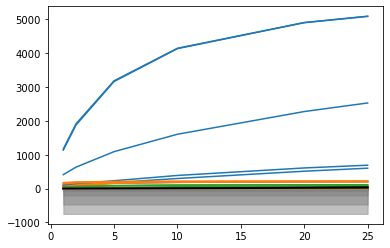

In [53]:
its_models = []
for j in msms:
    its_models.append(deeptime.util.validation.implied_timescales(j))
    deeptime.plots.plot_implied_timescales(its_models[-1])


In [ ]:
dtrajs = clusters.transform(dihedral_concat)

In [ ]:
lagtimes = [1,2,5,10,20,25]
countm = []
for j in lagtimes:
    estimator = deeptime.markov.TransitionCountEstimator(j, 'sliding')
    countm.append(estimator.fit(dtrajs).fetch_model())
countm

In [ ]:
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
msms = []
for matrix in countm:
    msms.append(estimator.fit(matrix).fetch_model())
#for j in msms:
#    print(j.transition_matrix)

In [ ]:
b = deeptime.util.validation.implied_timescales(msms)
c = deeptime.plots.plot_implied_timescales(b)
c.set_ylim((0,20))

In [ ]:
#its = pyemma.msm.its(clusters.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')
#its = deeptime.util.validation.implied_timescales(clusters, n_its=4)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, k in enumerate([20, 50, 100]):
    cluster = pyemma.coordinates.cluster_kmeans(data, k=k, max_iter=50, stride=10)
    pyemma.plots.plot_density(*data_concatenated.T, ax=axes[0, i], cbar=False, alpha=0.1)
    axes[0, i].scatter(*cluster.clustercenters.T, s=15, c='C1')
    axes[0, i].set_xlabel('$\Phi$')
    axes[0, i].set_ylabel('$\Psi$')
    axes[0, i].set_title('k = {} centers'.format(k))
    pyemma.plots.plot_implied_timescales(
        pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes'),
        ax=axes[1, i], units='ps')
    axes[1, i].set_ylim(1, 2000)
fig.tight_layout()